In [ ]:
import pandas as pd
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
df = pd.read_parquet('/home/bcthakreda/mlops_zoomcamp/Machine-Learning-ZoomCamp/week1/data/yellow_tripdata_2021-01.parquet')


In [ ]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [ ]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

In [14]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [15]:
dv = DictVectorizer()

In [16]:
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

6.85695803396992

/home/bcthakreda/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bcthakreda/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


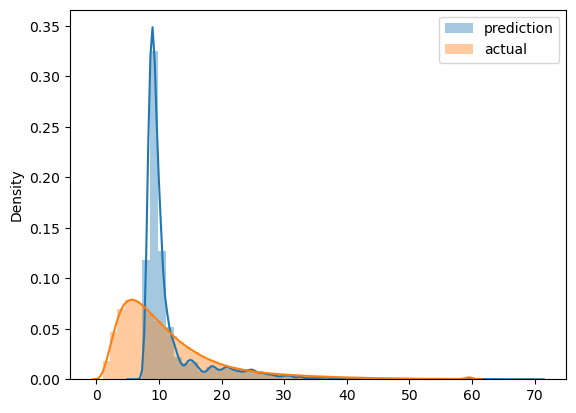

In [17]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [18]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [19]:
df_train = read_dataframe('/home/bcthakreda/mlops_zoomcamp/Machine-Learning-ZoomCamp/week1/data/yellow_tripdata_2021-01.parquet')
df_val = read_dataframe('/home/bcthakreda/mlops_zoomcamp/Machine-Learning-ZoomCamp/week1/data/yellow_tripdata_2021-02.parquet')

In [21]:
len(df_train), len(df_val)

(1343254, 1340859)

In [22]:
df_train.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

In [25]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [26]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

4.9844204028647905

In [52]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
output_path = os.path.join(parent_directory,'models','lr.bin')

In [53]:
with open(output_path, 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [54]:
lasso = Lasso(0.1)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.294382085838597

In [55]:
output_path = os.path.join(parent_directory,'models','lasso.bin')

In [56]:
with open(output_path, 'wb') as f_out:
    pickle.dump((dv, lasso), f_out)